# 

In [50]:
import geopandas as gpd 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import osmnx as ox

步骤一：矢量数据读取

In [17]:
traj_data=gpd.read_file(r"C:\Users\周昊\Desktop\时空大数据上机\上机01-轨迹数据聚合与建模\轨迹数据\上海研究区逐小时轨迹点_shp")

type(traj_data)

In [18]:
traj_data.head(10)

,ID,Time,Lon,Lat,Speed,Dir,Passage,geometry
0,10109,2007-02-20,121.4311,31.1796,50,0,0,POINT (121.43110 31.17960)
1,10109,2007-02-20,121.4315,31.1825,46,0,0,POINT (121.43150 31.18250)
2,10109,2007-02-20,121.4318,31.1848,62,0,0,POINT (121.43180 31.18480)
3,10109,2007-02-20,121.4323,31.1865,16,0,0,POINT (121.43230 31.18650)
4,10109,2007-02-20,121.4323,31.1890,42,0,0,POINT (121.43230 31.18900)
5,10109,2007-02-20,121.4326,31.1906,40,0,0,POINT (121.43260 31.19060)
6,10109,2007-02-20,121.4338,31.1913,30,22,0,POINT (121.43380 31.19130)
7,10109,2007-02-20,121.4355,31.1913,46,45,0,POINT (121.43550 31.19130)
8,10109,2007-02-20,121.4373,31.1915,0,22,0,POINT (121.43730 31.19150)
9,10109,2007-02-20,121.4385,31.1918,42,45,0,POINT (121.43850 31.19180)


<Axes: >

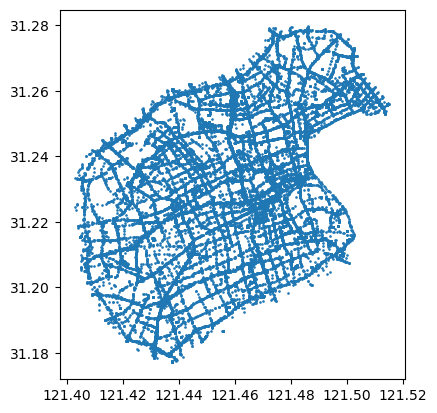

In [19]:
traj_data.plot(markersize=0.8)

将点数据和路网数据聚合，下载研究区内的OSM数据，采用OSMNX这个包


In [49]:
import osmnx as ox

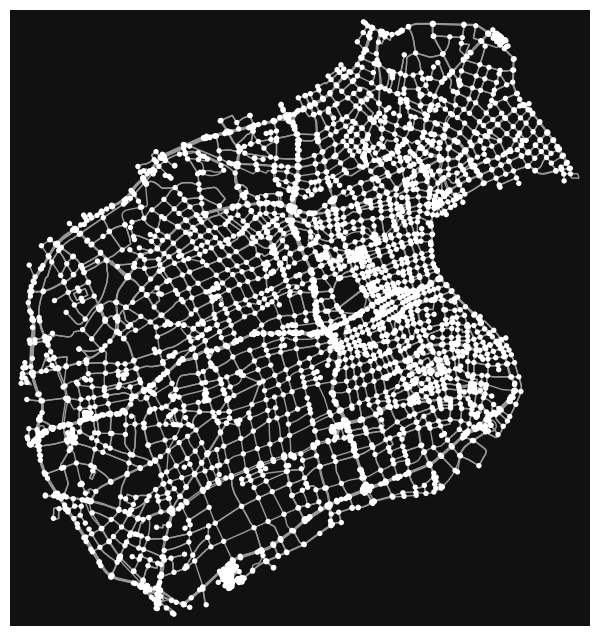

In [25]:

border_shp = gpd.read_file(r"C:\Users\周昊\Desktop\时空大数据上机\上机01-轨迹数据聚合与建模\研究区\上海研究区.shp")
border_geom = border_shp.geometry[0]
G=ox.graph.graph_from_polygon(border_geom,network_type='drive')
fig,ax=ox.plot_graph(G)


In [26]:
import pyproj

In [27]:
border_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
border_shp=border_shp.to_crs(crs='EPSG:32649')

border_shp.crs

In [29]:
#改函数来自于：https://zhuanlan.zhihu.com/p/636226208
def make_grid(gdf,cellsize,what='polygons',square=True):
    
    '''
        gdf : 矢量面要素,geopandas的GeoDataFrame;
        
        cellsize : 数字类型;格网大小;
        
        what : 字符串类型; 可选"polygons"或者"centers"
               前者为矢量面，后者为矢量面的中心;默认创建矢量面
               
        square : 布尔类型;创建的格网形状;
                 True为正方形格网、False为六边形格网;
                 默认创建正方形格网
    '''
    
    from shapely import geometry
    
    minX, minY, maxX, maxY =  gdf.bounds.values.reshape(-1,1)
    minX, minY, maxX, maxY =  minX[0], minY[0], maxX[0], maxY[0]
    x, y = (minX, minY)
    geom_array = []
    
    if square:
        while y <= maxY:
            while x <= maxX:
                geom = geometry.Polygon([(x,y), (x, y+cellsize), (x+cellsize, y+cellsize), (x+cellsize, y), (x, y)])
                geom_array.append(geom)
                x += cellsize
            x = minX
            y += cellsize
    else:
        i = 1
        while y <= maxY:
            while x <= maxX:
                geom = geometry.Polygon([(x,y-cellsize), 
                                         (x+pow(3,0.5)/2*cellsize, y-0.5*cellsize), 
                                         (x+pow(3,0.5)/2*cellsize, y+0.5*cellsize), 
                                         (x,y+cellsize),
                                         (x-pow(3,0.5)/2*cellsize, y+0.5*cellsize),
                                         (x-pow(3,0.5)/2*cellsize, y-0.5*cellsize), 
                                         (x,y-cellsize)])
                geom_array.append(geom)
                x += pow(3,0.5)*cellsize
                
            i += 1
            y += 1.5*cellsize
            
            if i % 2 == 0:   
                x = minX + pow(3,0.5)/2*cellsize
            else:
                x = minX
            

    gdf_grid = gpd.GeoDataFrame(geometry = geom_array,
                                crs = gdf.crs)
        
    if what == 'centers':
        gdf_grid = gpd.GeoDataFrame(geometry = gdf_grid.geometry.centroid,
                                    crs = gdf.crs)
        
    return gdf_grid


In [31]:
border_square = make_grid(border_shp,500)

<Axes: >

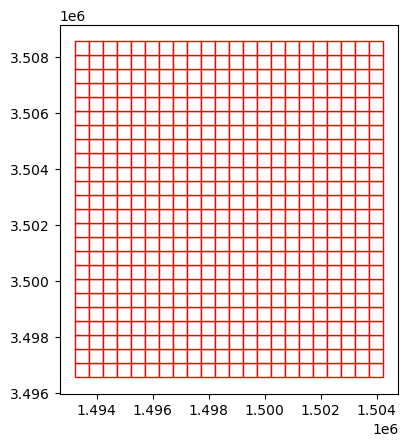

In [32]:
border_square.plot(facecolor='white',edgecolor='red')


<Axes: >

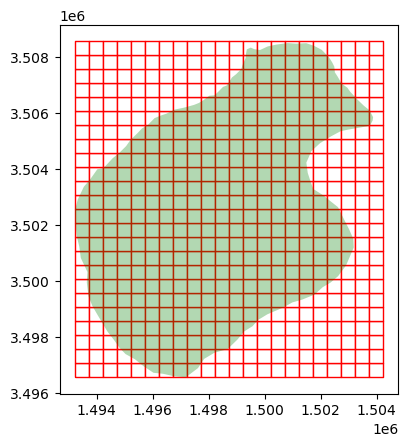

In [33]:
ax=border_square.plot(facecolor='white',edgecolor='red')
border_shp.plot(fc='green',ax=ax,alpha=0.3)

In [34]:
border_square.head(10)

,geometry
0,"POLYGON ((1493230.807 3496564.687, 1493230.807..."
1,"POLYGON ((1493730.807 3496564.687, 1493730.807..."
2,"POLYGON ((1494230.807 3496564.687, 1494230.807..."
3,"POLYGON ((1494730.807 3496564.687, 1494730.807..."
4,"POLYGON ((1495230.807 3496564.687, 1495230.807..."
5,"POLYGON ((1495730.807 3496564.687, 1495730.807..."
6,"POLYGON ((1496230.807 3496564.687, 1496230.807..."
7,"POLYGON ((1496730.807 3496564.687, 1496730.807..."
8,"POLYGON ((1497230.807 3496564.687, 1497230.807..."
9,"POLYGON ((1497730.807 3496564.687, 1497730.807..."


In [35]:
type(border_square)


geopandas.geodataframe.GeoDataFrame

In [36]:
border_square['gridID']=range(border_square.shape[0])

border_square.head(10)

In [38]:
border_square.crs

<Projected CRS: EPSG:32649>
Name: WGS 84 / UTM zone 49N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°E and 114°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Hong Kong. Indonesia. Macao. Malaysia - East Malaysia - Sarawak. Mongolia. Russian Federation. Vietnam.
- bounds: (108.0, 0.0, 114.0, 84.0)
Coordinate Operation:
- name: UTM zone 49N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
traj_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
traj_data=traj_data.to_crs('EPSG:32649')

In [43]:
intersect_re=gpd.overlay(traj_data,border_square,'intersection')

In [44]:
intersect_re.head(10)

,ID,Time,Lon,Lat,Speed,Dir,Passage,gridID,geometry
0,10109,2007-02-20,121.4311,31.1796,50,0,0,6,POINT (1496504.344 3496794.710)
1,3206,2007-02-20,121.4313,31.1790,50,0,0,6,POINT (1496529.936 3496729.531)
2,3206,2007-02-20,121.4311,31.1798,14,0,0,6,POINT (1496502.215 3496817.046)
3,3206,2007-02-20,121.4315,31.1813,52,0,0,6,POINT (1496524.654 3496988.231)
4,3443,2007-02-20,121.4298,31.1816,74,157,1,6,POINT (1496358.227 3497006.176)
5,4315,2007-02-20,121.4316,31.1800,40,22,1,6,POINT (1496548.096 3496843.959)
6,4315,2007-02-20,121.4306,31.1805,20,90,0,6,POINT (1496446.753 3496890.648)
7,5122,2007-02-20,121.4311,31.1813,62,157,0,6,POINT (1496486.246 3496984.570)
8,5122,2007-02-20,121.4310,31.1805,64,90,0,6,POINT (1496485.161 3496894.309)
9,5164,2007-02-20,121.4313,31.1801,30,0,0,6,POINT (1496518.226 3496852.382)


In [45]:
exist_gridID=intersect_re['gridID'].unique()

In [46]:
exist_gridID


array([  6,  28,  50,  72,  73,  74,  96, 119, 142, 143, 166, 167, 210,
       254, 297, 340, 384, 406, 427, 450, 428, 295, 267, 234, 268, 269,
       291, 270, 292, 294, 273, 296, 275, 232, 233, 255, 277, 299, 300,
       301, 323, 344, 322, 343, 321, 320, 342, 355, 356, 378, 379, 358,
       359, 405, 383, 407, 385, 408, 430, 386, 409, 431, 410, 388, 387,
       112, 134, 156, 199, 220, 242, 287, 310, 289, 288, 266, 223, 201,
       200, 520, 498, 476, 455, 456, 453, 474, 195, 194, 216, 215, 214,
       213, 235, 256, 212, 190, 168, 145, 188, 209, 231, 252, 253, 276,
       318, 362, 193, 382, 404, 381, 360, 339, 317, 316, 315, 293, 290,
       248, 247, 225, 246, 314, 337, 338, 336, 313, 245, 222, 221, 496,
       519, 211, 164, 121,  99, 144, 169, 192, 236, 403, 361, 274, 298,
       124, 147, 148, 171, 191, 251, 204, 158, 133,  27,  49,  97, 120,
       224, 202, 180, 114,  92,  71,  95,  75,  54,  76,  53,  30,   7,
        48,  90,  26, 259, 258, 186, 165, 118,  70,  91,  89, 23

In [47]:
exsit_gridID=list(exist_gridID)

In [48]:
len(exist_gridID)

337

In [49]:
square_select=border_square[border_square['gridID'].isin(exist_gridID)]

<Axes: >

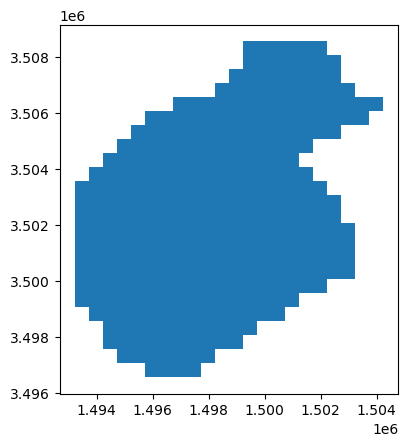

In [50]:
square_select.plot()

In [48]:
square_select.plot(column='gridID',cmap='hot',edgecolor='gray',legend=True)


NameError: name 'square_select' is not defined

In [54]:
r=exsit_gridID[0]

In [59]:
traj_data_r=intersect_re[intersect_re['gridID']==r]
traj_data_r.head()

,ID,Time,Lon,Lat,Speed,Dir,Passage,gridID,geometry
0,10109,2007-02-20,121.4311,31.1796,50,0,0,6,POINT (1496504.344 3496794.710)
1,3206,2007-02-20,121.4313,31.1790,50,0,0,6,POINT (1496529.936 3496729.531)
2,3206,2007-02-20,121.4311,31.1798,14,0,0,6,POINT (1496502.215 3496817.046)
3,3206,2007-02-20,121.4315,31.1813,52,0,0,6,POINT (1496524.654 3496988.231)
4,3443,2007-02-20,121.4298,31.1816,74,157,1,6,POINT (1496358.227 3497006.176)


In [60]:
traj_data_r.shape

(134, 9)

In [62]:
len(traj_data_r['ID'].unique())

48